# Wstępna analiza IUM
Paweł Bęza <br>
Artur Mazur

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import calendar

%load_ext autoreload
%autoreload 2

## Problem biznesowy
<blockquote>
Chcemy przewidzieć czy dana sesja użytkownika zakończy się zakupem na podstawie danych sesji.
Skuteczna klasyfikacja sesji, które zakończą się zakupem umożliwi konsultantom szybsze rozwiązywanie problemów
</blockquote>

## Zadanie modelowania
Zadaniem jest klasyfikacja binarna odpowiadająca na pytanie "Czy sesja użytkownika zakończy się zakupem?".
Do dyspozycji mamy historyczne dane składające się z:
* bazy użytkowników
* katalogu produktów
* historia sesji
* dane dotyczące wysyłki zakupionych produktów

## Analiza zbioru danych
Najpierw zastanowilismy się, do których informacji mamy dostęp w trakcie trwania sesji.

Zauważyliśmy, że dane dotyczące wysyłki są dostępne dopiero po dokonaniu zakupu, dlatego z tej informacji nie będziemy mogli skorzystać.
Informacje zawarte w pozostałych tabelach są dostępne w trakcie trwania sesji, więc przeszliśmy do bardziej szczegółowej analizy tego fragmentu danych.

Postanowiliśmy wyróżnić ze zbioru danych następujące informacje:
* *user_id* - identyfikator użytkownika
* [*purchase*](#purchase) - wartość boolowska odpowiadająca na pytanie czy sesja zakończyła się zakupem
* [*weekend*](#weekend) - wartość boolowska odpowiadająca na pytanie czy sesja trwa w weekend
* *month*, [*weekday*](#weekday), *day*, [*hour*](#hour) - miesiąc, dzień tygodnia, dzień miesiąca, godzina
* [*offered_discount*](#discount) - wysokość zniżki
* [*duration*](#duration) - długość trwania sesji w sekundach
* [*click_rate*](#click_rate) - liczba zdarzeń(event'ów) do aktualnego rekordu na minutę
* *item_views* - liczba obejrzanych przedmiotów
* [*unique_item_views*](#unique_item_views) - liczba przejrzanych unikalnych przedmiotów
* [*unique_categories*](#unique_categories) - liczba przejrzanych unikalnych kategorii

Powyższe informacje zapisaliśmy w pliku *merged_dataset*

### Przykładowe rekordy zawierające powyższe informacje

In [2]:
sessions = pd.read_csv("merged_dataset", sep=' ')
sessions.head()

,Unnamed: 0,session_id,user_id,offered_discount,duration,weekend,month,weekday,day,hour,unique_item_views,item_views,click_rate,unique_categories,purchase
0,0,100001,102.0,20,0.0,False,January,1.0,26.0,14.0,1.0,1.0,0.000000,1.0,True
1,1,100001,102.0,20,88.0,False,January,1.0,26.0,14.0,2.0,2.0,1.363636,2.0,True
2,2,100001,102.0,20,180.0,False,January,1.0,26.0,14.0,3.0,3.0,1.000000,2.0,True
3,3,100001,102.0,20,185.0,False,January,1.0,26.0,14.0,4.0,4.0,1.297297,2.0,True
4,4,100001,102.0,20,471.0,False,January,1.0,26.0,14.0,5.0,5.0,0.636943,2.0,True


In [3]:
current_id = 0
day_buying_sessions = np.zeros(7)
day_sessions = np.zeros(7)
for i in range(sessions.shape[0]):
    if(sessions.iloc[i]['session_id'] != current_id):
        session = sessions.iloc[i]
        current_id = session['session_id']
        day_sessions[int(session['weekday'])] += 1
        
        if(session['purchase']):
            day_buying_sessions[int(session['weekday'])] += 1

In [4]:
def autolabel(rects, ax):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 0),  
                    textcoords="offset points",
                    ha='center', va='bottom')

### Ile sesji zakończyło się zakupem? <a name="purchase"></a>
Liczba sesji w obu klasach jest porównywalna dlatego można powiedzieć, że mamy styczność z danymi zbalansowanymi.

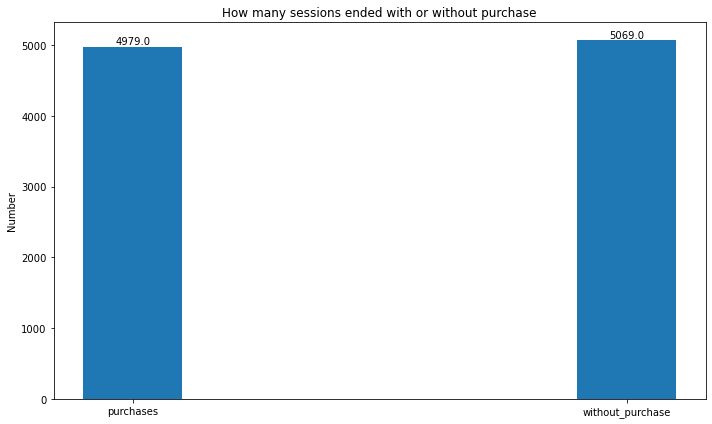

In [5]:
labels = ['purchases', 'without_purchase']

buying_sessions = sum(day_buying_sessions)
values = [buying_sessions, sum(day_sessions) - buying_sessions]

x = np.arange(len(labels))
width = 0.2

fig, ax = plt.subplots(figsize=(10,6))
rects = ax.bar(x, values, width)

ax.set_ylabel('Number')
ax.set_title('How many sessions ended with or without purchase')
ax.set_xticks(x)
ax.set_xticklabels(labels)

autolabel(rects, ax)

fig.tight_layout()

plt.show()

### Weekend <a name="weekend"></a>
Analizując to czy sesja trwa w weekend chceiliśmy zweryfikować czy w weekend jest więcej sesji ogólem oraz w szczególności tych kupujących.

### Liczba sesji ogółem
* w trakcie dni roboczych jest w sumie ~2.4 więcej sessji niż podczas weekendu
* średnia dzienna liczba sesji w weekend jest o ~4.5% większa niż w dni robocze

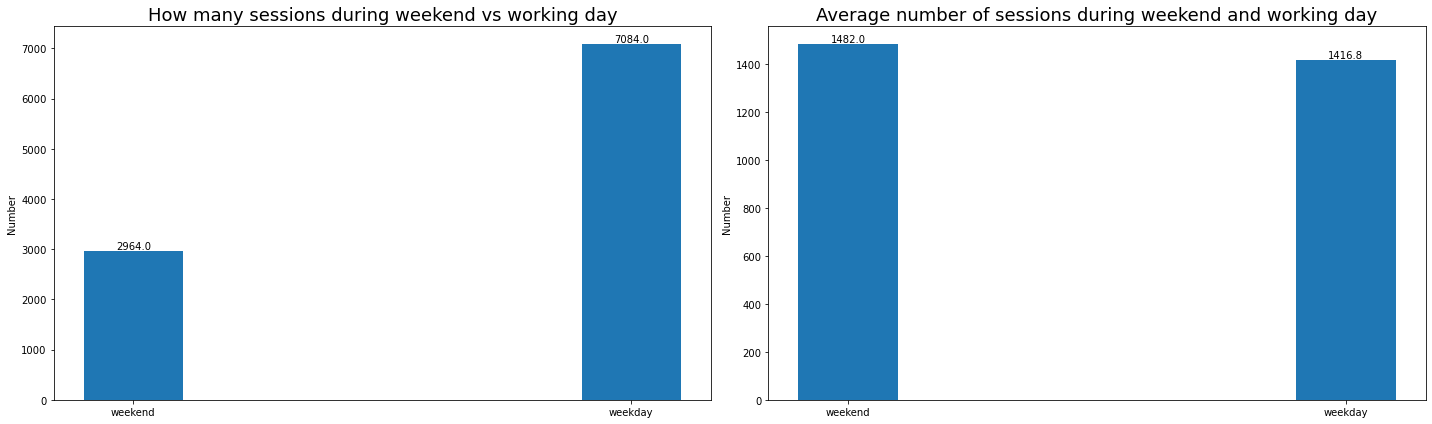

In [6]:
labels = ['weekend', 'weekday']

x = np.arange(len(labels))
width = 0.2

fig, axs = plt.subplots(ncols=2, figsize=(20,6))

values = [sum(day_sessions[5:]), sum(day_sessions[:5])]
rects = axs[0].bar(x, values, width)

axs[0].set_ylabel('Number')
axs[0].set_title('How many sessions during weekend vs working day', fontsize=18)
axs[0].set_xticks(x)
axs[0].set_xticklabels(labels)

autolabel(rects, axs[0])

values_avg = [values[0] / 2, values[1] / 5]
rects_avg = axs[1].bar(x, values_avg, width)

axs[1].set_ylabel('Number')
axs[1].set_title('Average number of sessions during weekend and working day', fontsize=18)
axs[1].set_xticks(x)
axs[1].set_xticklabels(labels)

autolabel(rects_avg, axs[1])

fig.tight_layout()

plt.show()

### Liczba sesji kupujących
* w trakcie dni roboczych jest ~2.36 więcej sesji kupujących niż podczas weekendu
* średnia liczba sesji kupujących w weekend jest o ~6% większa niż w trakcie dni roboczych

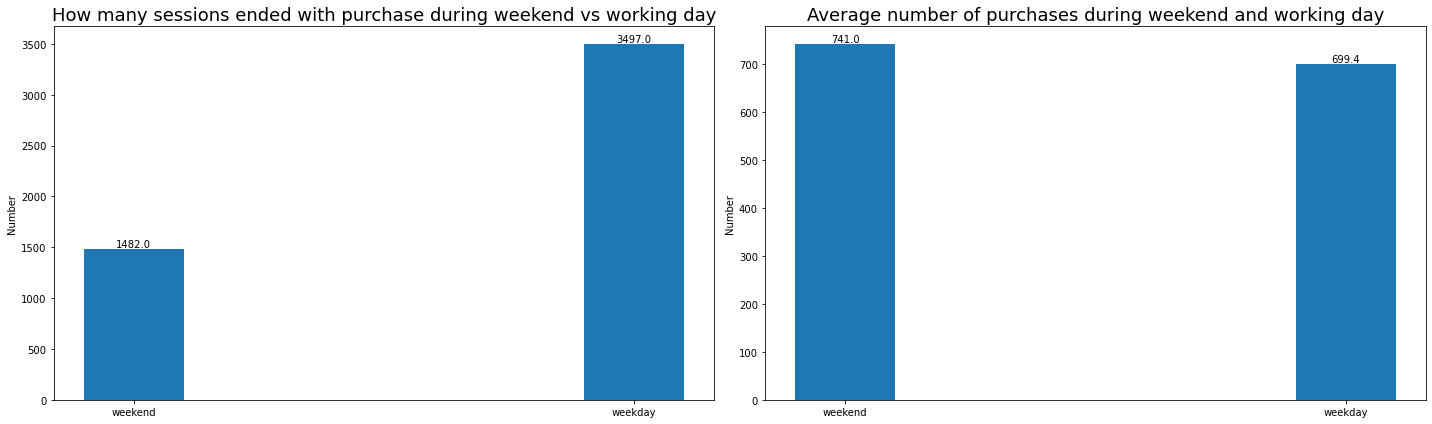

In [8]:
labels = ['weekend', 'weekday']
values = [sum(day_buying_sessions[5:]), sum(day_buying_sessions[:5])]

x = np.arange(len(labels))
width = 0.2

fig, axs = plt.subplots(ncols=2, figsize=(20,6))
rects = axs[0].bar(x, values, width)

axs[0].set_ylabel('Number')
axs[0].set_title('How many sessions ended with purchase during weekend vs working day', fontsize=18)
axs[0].set_xticks(x)
axs[0].set_xticklabels(labels)

autolabel(rects, axs[0])

values_avg = [values[0]/2, values[1]/5]
rects_avg = axs[1].bar(x, values_avg, width)

axs[1].set_ylabel('Number')
axs[1].set_title('Average number of purchases during weekend and working day', fontsize=18)
axs[1].set_xticks(x)
axs[1].set_xticklabels(labels)

autolabel(rects_avg, axs[1])

fig.tight_layout()

plt.show()

### Weekday <a name="weekday"></a>
Analizując poszczególne tygodnia chcieliśmy sprawdzić w jaki dni tygodnia jest najwięcej sesji ogółem oraz kiedy jest najwięcej sesji kupujących

* w piątek jest największa liczba sesji ogółem
* w sobotę jest najwieksza liczba sesji kupujących
* im bliżej weekendu tym większy "ruch" w sklepie

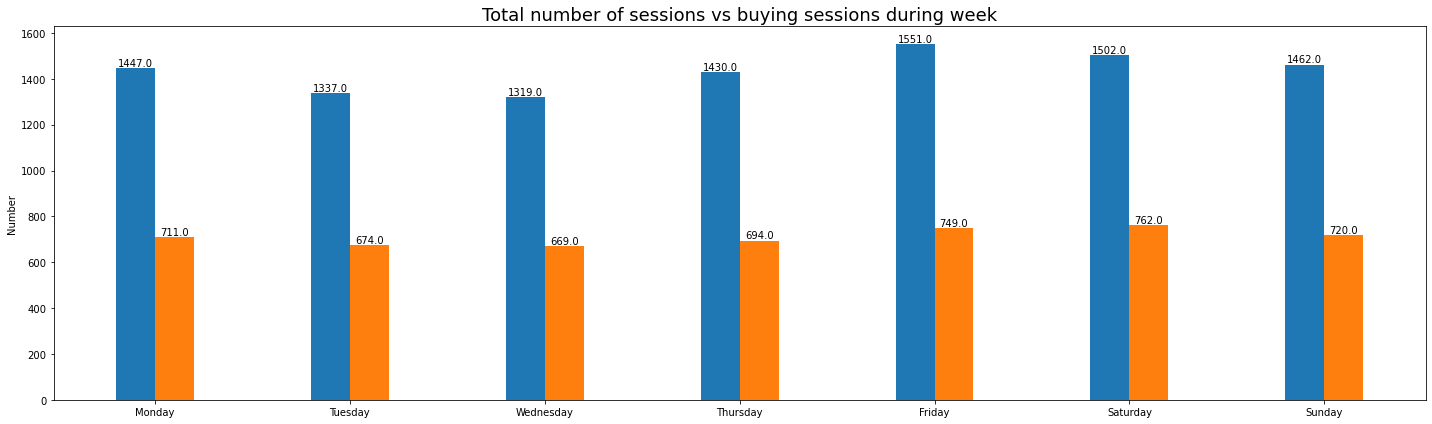

In [9]:
labels = list(calendar.day_name)
x = np.arange(len(labels))
width = 0.2

fig, ax = plt.subplots(figsize=(20,6))
rects1 = ax.bar(x - width/2, day_sessions, width, label='total sessions')
rects2 = ax.bar(x + width/2, day_buying_sessions, width, label='buying sessions')

ax.set_ylabel('Number')
ax.set_title('Total number of sessions vs buying sessions during week', fontsize=18)
ax.set_xticks(x)
ax.set_xticklabels(labels)

autolabel(rects1, ax)
autolabel(rects2, ax)
fig.tight_layout()

plt.show()

In [10]:
current_id = 100001
session_hour_pur = np.zeros(24)
session_hour_without = np.zeros(24)
current_duration = 0
purchase = False
data_set = []
for i in range(sessions.shape[0]):
    if(sessions.iloc[i]['session_id'] != current_id):
        temp = [current_id, current_duration, purchase]
        data_set.append(temp)
        current_id = sessions.iloc[i]['session_id']
        current_duration = sessions.iloc[i]['duration']
        purchase = sessions.iloc[i]['purchase']
        if(purchase):
            session_hour_pur[int(sessions.iloc[i]['hour'])] += 1
        else:
            session_hour_without[int(sessions.iloc[i]['hour'])] += 1
    else:
        current_duration = sessions.iloc[i]['duration']
        
temp = [current_id, current_duration, purchase]
data_set.append(temp)

### Hour  <a name="hour"></a>
Analizując godzinę rozpoczęcia sesji chcieliśmy sprawdzić kiedy klienci mają najwiekszą tendencję do zakupów
* najwięcej sesji kupujących jest w okolicach 6:00, 13:00 oraz 18:00

In [11]:
hours = sessions['hour'].unique()
hours.sort()
hours

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23.])

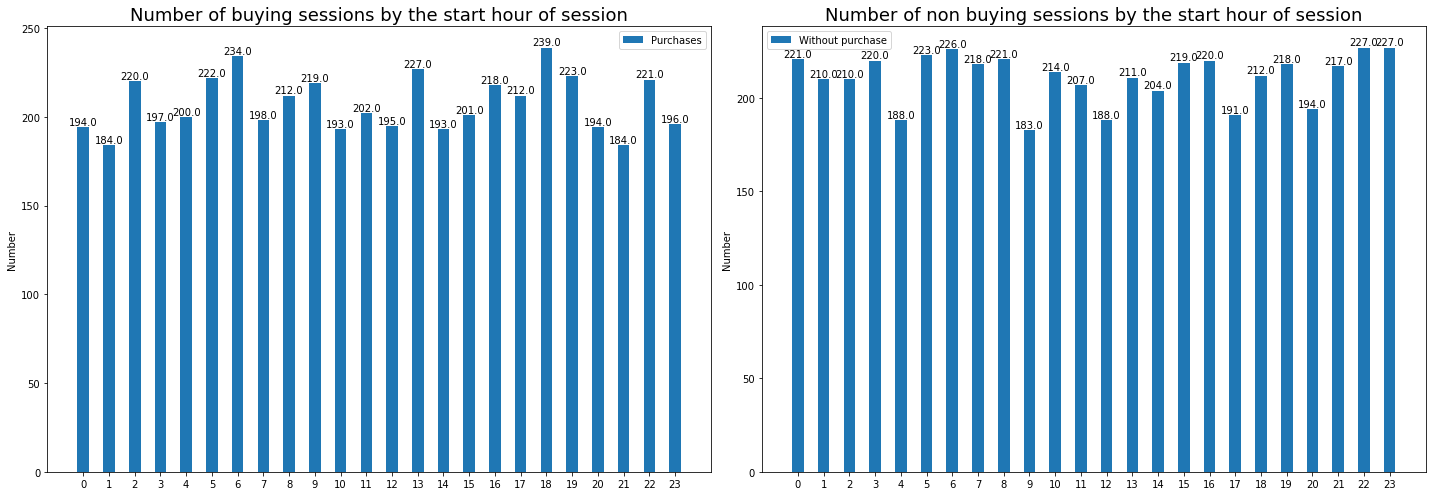

In [12]:
labels = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14',
          '15', '16', '17', '18', '19', '20', '21', '22', '23']

x = np.arange(len(labels))
width = 0.45

fig, axs = plt.subplots(ncols=2, figsize=(20,7))

rects1 = axs[0].bar(x, session_hour_pur, width, label='Purchases')

axs[0].set_ylabel('Number')
axs[0].set_title('Number of buying sessions by the start hour of session', fontsize=18)
axs[0].set_xticks(x)
axs[0].set_xticklabels(labels)
axs[0].legend()

autolabel(rects1, axs[0])

rects2 = axs[1].bar(x, session_hour_without, width, label='Without purchase')

axs[1].set_ylabel('Number')
axs[1].set_title('Number of non buying sessions by the start hour of session', fontsize=18)
axs[1].set_xticks(x)
axs[1].set_xticklabels(labels)
axs[1].legend()

autolabel(rects2, axs[1])

fig.tight_layout()

plt.show()

In [13]:
difference = []
for i in range(len(session_hour_pur)):
    difference.append(session_hour_pur[i] - session_hour_without[i])

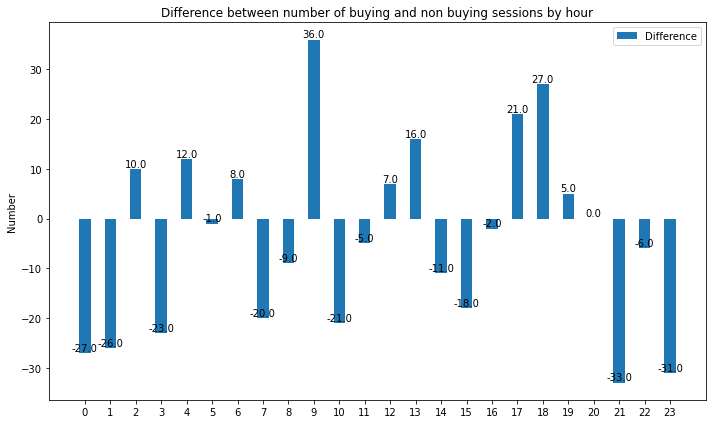

In [14]:
fig, ax = plt.subplots(figsize=(10,6))
rects1 = ax.bar(x, difference, width, label='Difference')

ax.set_ylabel('Number')
ax.set_title('Difference between number of buying and non buying sessions by hour')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

autolabel(rects1, ax)

fig.tight_layout()

plt.show()    

In [ ]:
purchases_discount = 0
purchases_without_d = 0
without_pur_discount = 0
without_pur_without_d = 0
current_id = 0
for i in range(sessions.shape[0]):
    if(sessions.iloc[i]['session_id'] != current_id):
        current_id = sessions.iloc[i]['session_id']
        if(sessions.iloc[i]['purchase']):
            if(sessions.iloc[i]['offered_discount']):
                purchases_discount += 1
            else:
                purchases_without_d += 1
        else:
            if(sessions.iloc[i]['offered_discount']):
                without_pur_discount += 1
            else:
                without_pur_without_d += 1

### Discount <a name="discount"></a>
Analizując zniżkę chcieliśmy sprawdzić jak sam fakt zaproponowania zniżki wpływa na decyzję zakupu, a także to jaki ma wpływ wysokość zniżki

### Bez proponowania zniżki
Liczba sesji nie zakończonych zakupem jest o ~2% więcej niż sesji zakończonych zakupem

### Z proponowaną zniżką
Liczba sesji nie zakończonych zakupem jest o ~1.5% więcej niż sesji zakończonych zakupem

Dlatego też obserwujemy, że fakt przyznania zniżki daje bardzo znikomą poprawę.

In [ ]:
labels = ['purchases', 'without_purchase']
with_discount = [purchases_discount, without_pur_discount]
without_discount = [purchases_without_d, without_pur_without_d]

x = np.arange(len(labels))
width = 0.2

fig, ax = plt.subplots(figsize=(10,6))
rects1 = ax.bar(x - width/2, with_discount, width, label='Discount')
rects2 = ax.bar(x + width/2, without_discount, width, label='Without discount')
                
ax.set_ylabel('Number')
ax.set_title('Number of buying vs non buying sesions with or without discount')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
                
autolabel(rects1, ax)
autolabel(rects2, ax)

fig.tight_layout()

plt.show()

### Wysokość zniżki
#### 5%
Liczba sesji nie zakończonych zakupem jest o ~4% więcej niż sesji zakończonych zakupem
#### 10%
Liczba sesji nie zakończonych zakupem jest o ~2% więcej niż sesji zakończonych zakupem
#### 15%
Liczba sesji nie zakończonych zakupem jest o ~4% więcej niż sesji zakończonych zakupem
#### 20%
Liczba sesji nie zakończonych zakupem jest o ~4% mniej niż sesji zakończonych zakupem

Po analizie różnic między liczbą sesji nie zakończonych, a zakończonych zakupem podejrzewamy, że podane dane są niepoprawne, ponieważ spodziewalibyśmy się, że im większa zniżka tym większa % sesji zakończonych zakupem.

In [ ]:
discounts = sessions['offered_discount'].unique()
discounts.sort()
discounts

In [ ]:
data = [[0,0], [0,0], [0,0], [0,0], [0,0]]
current_id = 0
for i in range(sessions.shape[0]):
    if(sessions.iloc[i]['session_id'] != current_id):
        current_id = sessions.iloc[i]['session_id']
        if(sessions.iloc[i]['purchase']):
            discount_index = sessions.iloc[i]['offered_discount']/5
            data[int(discount_index)][0] += 1
        else:
            discount_index = sessions.iloc[i]['offered_discount']/5
            data[int(discount_index)][1] += 1
            
if(sessions.iloc[i]['purchase']):
    discount_index = sessions.iloc[i]['offered_discount']/5
    data[int(discount_index)][0] += 1
else:
    discount_index = sessions.iloc[i]['offered_discount']/5
    data[int(discount_index)][1] += 1


In [ ]:
labels = ['0', '5', '10', '15', '20']
purchases = [data[0][0], data[1][0], data[2][0], data[3][0], data[4][0]]
without_purchases = [data[0][1], data[1][1], data[2][1], data[3][1], data[4][1]]

x = np.arange(len(labels))
width = 0.45

fig, ax = plt.subplots(figsize=(10,6))
rects1 = ax.bar(x - width/2, purchases, width, label='Purchases')
rects2 = ax.bar(x + width/2, without_purchases, width, label='Without purchase')
                
ax.set_ylabel('Amount')
ax.set_title('Amount by purcheses and discount')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
                
autolabel(rects1, ax)
autolabel(rects2, ax)

fig.tight_layout()

plt.show()

### Duration <a name="duration"></a>
Doprecyzowując jest to długość trwania sesji do momentu zalogowania danego eventu, a nie długość całkowita tzn. długość sesji obliczamy jako:
$session\_event\_timestamp - session\_start\_timestamp$ gdzie: <br> *session_event_timestamp* - timestamp eventu z tabeli *sessions* <br> *session_event_timestamp* - timestamp eventu, który nastąpił najwcześniej podczas trwania sesji, do której należy dany rekord

Analizując długosć trwania sesji chcieliśmy zweryfikować jaki wpływ na kupno ma długość trwania sesji.

In [ ]:
purchases = []
without_p = []

current_id = 0
for i in range(len(data_set)):
    if(sessions.iloc[i]['session_id'] != current_id):
        current_id = sessions.iloc[i]['session_id']
        if(data_set[i][2]):
            purchases.append(data_set[i][1])
        else:
            without_p.append(data_set[i][1])

pur_time = np.array(purchases)
without_pur_time = np.array(without_p)

In [ ]:
df = pd.DataFrame({"Average" : [np.average(pur_time), np.average(without_pur_time)],
                   "Median" : [np.median(pur_time), np.median(without_pur_time)],
                   "Min" : [np.min(pur_time), np.min(without_pur_time)],
                   "Max" : [np.max(pur_time), np.max(without_pur_time)],
                   "Variance" : [np.var(pur_time), np.var(without_pur_time)],
                   "Standard deviation" : [np.std(pur_time), np.std(without_pur_time)],
                   "Amount" : [len(pur_time), len(without_pur_time)]})
df = df.rename(index={0 : "Purchases", 1 : "Without Purchase"})
df

In [ ]:
purchase = np.zeros(24)
current_id = 0
for i in range(len(pur_time)):
    purchase[int(pur_time[i]/100)] += 1

In [ ]:
without = np.zeros(24)
for i in range(len(without_pur_time)):
    without[int(without_pur_time[i]/100)] += 1

In [ ]:
labels = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13',
          '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24']

x = np.arange(len(labels))
width = 0.35

fig, axs = plt.subplots(ncols=2, figsize=(20,6))

axs[0].bar(x, purchase, width)
print(purchase.shape)

axs[0].set_ylabel('Number')
axs[0].set_title('Duration of buying session in minutes (rounded up)', fontsize=18)
axs[0].set_xticks(x)
axs[0].set_xticklabels(labels)

axs[1].bar(x, without, width)

axs[1].set_ylabel('Number')
axs[1].set_title('Duration of non-buying session in minutes (rounded up)', fontsize=18)
axs[1].set_xticks(x)
axs[1].set_xticklabels(labels)

plt.show()

### unique_item_views <a name="unique_item_views"></a>

In [ ]:
max_items = 0
max_categories = 0
current_session = 100001 
items_shown = []
items_shown_w = []
categories_shown = []
categories_shown_w = []

for i in range(sessions.shape[0]):
    if(sessions.iloc[i]['session_id'] != current_session):
        if(sessions.iloc[i]['purchase']):
            items_shown.append(max_items)
            categories_shown.append(max_categories)
        else:
            items_shown_w.append(max_items)
            categories_shown_w.append(max_categories)
        current_session = sessions.iloc[i]['session_id']
    max_items = sessions.iloc[i]['unique_item_views']
    max_categories = sessions.iloc[i]['unique_categories']

In [ ]:
unique, counts = np.unique(np.array(items_shown), return_counts = True)
unique_w, counts_w = np.unique(np.array(items_shown_w), return_counts = True)

In [ ]:
x = np.arange(len(unique))
width = 0.45

fig, ax = plt.subplots(figsize=(10,6))
rects1 = ax.bar(x - width/2, counts, width, label='Purchases')
rects2 = ax.bar(x + width/2, counts_w, width, label='Without purchase')
                
ax.set_ylabel('Amount')
ax.set_title('Amount of shown items by purcheses')
ax.set_xticks(x)
ax.set_xticklabels(unique)
ax.legend()
                
autolabel(rects1, ax)
autolabel(rects2, ax)

fig.tight_layout()

plt.show()

### unique_categories <a name="unique_categories"></a>

In [ ]:
unique, counts = np.unique(np.array(categories_shown), return_counts = True)
unique_w, counts_w = np.unique(np.array(categories_shown_w), return_counts = True)

In [ ]:
x = np.arange(len(unique))
width = 0.45

fig, ax = plt.subplots(figsize=(10,6))
rects1 = ax.bar(x - width/2, counts, width, label='Purchases')
rects2 = ax.bar(x + width/2, counts_w, width, label='Without purchase')
                
ax.set_ylabel('Amount')
ax.set_title('Amount of shown categories by purcheses')
ax.set_xticks(x)
ax.set_xticklabels(unique)
ax.legend()
                
autolabel(rects1, ax)
autolabel(rects2, ax)

fig.tight_layout()

plt.show()

### click_rate <a name="click_rate"></a>

In [ ]:
click_rate = 0
current_session = 100001 
click_rate_p = []
click_rate_w = []

for i in range(sessions.shape[0]):
    if(sessions.iloc[i]['session_id'] != current_session):
        if(sessions.iloc[i]['purchase']):
            click_rate_p.append(click_rate)
        else:
            click_rate_w.append(click_rate)
        current_session = sessions.iloc[i]['session_id']
    click_rate = sessions.iloc[i]['click_rate']

In [ ]:
df = pd.DataFrame({"Average" : [np.average(click_rate_p), np.average(click_rate_w)],
                   "Median" : [np.median(click_rate_p), np.median(click_rate_w)],
                   "Min" : [np.min(click_rate_p), np.min(click_rate_w)],
                   "Max" : [np.max(click_rate_p), np.max(click_rate_w)],
                   "Variance" : [np.var(click_rate_p), np.var(click_rate_w)],
                   "Standard deviation" : [np.std(click_rate_p), np.std(click_rate_w)],
                   "Amount" : [len(click_rate_p), len(click_rate_w)]})
df = df.rename(index={0 : "Purchases", 1 : "Without Purchase"})
df

## Literatura
* [Towards early purchase intention prediction in online session based retailing systems]("https://link.springer.com/article/10.1007/s12525-020-00448-x")